<a href="https://colab.research.google.com/github/ian-byrne/MADSmilestone2/blob/main/SIADS695_clock_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project is inspired by the AI Crowd Challenge: https://www.aicrowd.com/challenges/addi-alzheimers-detection-challenge

Data from NHATs: https://nhats.org/researcher/data-access


Meta file crosswalk: https://www.nhats.org/sites/default/files/2021-07/NHATS_R10_Final_Crosswalk_between_Instruments_and_Codebook.pdf

User Guide: https://www.nhats.org/sites/default/files/2021-07/NHATS_User_Guide_R10_Final_Release.pdf

In [ ]:
# contains all the clock images for round 1.  arn:aws:s3:::clockdrawingimages1
# URL of a single clock image from round 1 (not all image file names increment by 1): https://clockdrawingimages1.s3.us-west-1.amazonaws.com/10000003.tif
# URI of a single clock image from round 1: s3://clockdrawingimages1/10000003.tif

# URL of a single clock image from round 2 (not all image file names increment by 1):https://clockdrawingimages2.s3.us-west-1.amazonaws.com/10000003.tif


# URL of a single clock image from round 2 (not all image file names increment by 1): https://clockdrawingimages3.s3.us-west-1.amazonaws.com/10000003.tif

In [ ]:
!pip install boto3
!pip install awscli

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
#from io import BytesIO
import boto3
import cv2 
import awscli


In [15]:
def load_data():
  """Load stata data from S3, rounds 1 - 10; contains diagnoses, scoring, subject ID to map to images
  hc1disescn9 : 1 - YES to dementia/Alzheimers, 2 - NO Dementia, may want to drop -9 and -1?, may need to relabel 7. 
  cg1dclkdraw: score of drawing
  spid: Subject ID, number maps to number in image file names"""

  values = [1,2]#, 3, 4, 5, 6, 7, 8, 9, 10] 
  round_data = pd.DataFrame()

  for val in values:
    data = pd.io.stata.read_stata('https://clockdrawingbattery.s3.us-west-1.amazonaws.com/NHATS_Round_'+str(val)+'_SP_File.dta')
    data = data[['spid','cg'+str(val)+'dclkdraw', 'hc'+str(val)+'disescn9']]
    data['round'] = val

    # Rename columns
    data.rename(columns={'cg'+str(val)+'dclkdraw': 'cg'+str(int(val/val))+'dclkdraw', 'hc'+str(val)+'disescn9': 'hc'+str(int(val/val))+'disescn9'}, inplace = True)
    round_data = round_data.append(data)
  
 
  return round_data





rounds_df = load_data()

In [16]:
print(rounds_df['cg1dclkdraw'].unique())
print(rounds_df['hc1disescn9'].unique())

['3 Mildly distorted depiction of a clock', '4 Reasonably accurate depiction of a clock', '-2 Proxy says cannot ask SP', '2 Moderately distorted depection of a clock', '-1 Inapplicable', ..., '1 Severely distorted depiction of a clock', '-4 SP did not attempt to draw clock', '0 Not recognizable as a clock', '-3 Proxy says can ask SP but SP unable to ans..., '-9 Missing']
Length: 12
Categories (12, object): ['-9 Missing' < '-7 SP refused to draw clock' <
                          '-4 SP did not attempt to draw clock' < '-3 Proxy says can ask SP but SP unable to ans... <
                          ... < '2 Moderately distorted depection of a clock' <
                          '3 Mildly distorted depiction of a clock' < '4 Reasonably accurate depiction of a clock' <
                          '5 Accurate depiction of a clock (circular or ...]
[' 2 NO' '-1 Inapplicable' ' 1 YES' '-9 Missing' '-8 DK' '2 NO'
 '7 PREVIOUSLY REPORTED' '1 YES']


In [17]:
rounds_df[rounds_df['cg1dclkdraw'] == '-1 Inapplicable']

,spid,cg1dclkdraw,hc1disescn9,round
6,10000009.0,-1 Inapplicable,-1 Inapplicable,1
8,10000013.0,-1 Inapplicable,-1 Inapplicable,1
10,10000015.0,-1 Inapplicable,-1 Inapplicable,1
33,10000046.0,-1 Inapplicable,-9 Missing,1
47,10000067.0,-1 Inapplicable,-9 Missing,1
...,...,...,...,...
7063,10012393.0,-1 Inapplicable,-1 Inapplicable,2
7066,10012396.0,-1 Inapplicable,-9 Missing,2
7069,10012402.0,-1 Inapplicable,-1 Inapplicable,2
7070,10012404.0,-1 Inapplicable,-1 Inapplicable,2


In [18]:
def clean_data(df):
  # Clean the row values in hc1disescn9 , cg1dclkdraw
  # hc1disescn9 asks if subject has dementia or alzheimers: 1 YES, 2 NO
  hc_items = [('2 NO', 2),(' 2 NO', 2), ('1 YES', 1),(' 1 YES', 1),
              ('-9 Missing', np.nan),('-8 DK', np.nan),('7 PREVIOUSLY REPORTED', 7),
              ('-1 Inapplicable', np.nan),('-7 RF', np.nan)]

  cg_items = [('-2 Proxy says cannot ask SP', np.nan), ('-7 SP refused to draw clock', np.nan), 
              ('-4 SP did not attempt to draw clock', np.nan), ('-3 Proxy says can ask SP but SP unable to answer', np.nan), 
              ('-1 Inapplicable', np.nan), ('-9 Missing', np.nan)]

  for item in hc_items:
    df.hc1disescn9.replace(item[0], item[1], inplace = True)

  # Remove cg1dclkdraw subjects that did not draw a clock, or image data is missing
  for item in cg_items:
    df.cg1dclkdraw.replace(item[0], item[1], inplace = True)

  
  # Drop all NaN
  df.dropna(inplace = True)

  return df


rounds_clean = clean_data(rounds_df)

In [19]:
#Check that we only have 1, 2, 7 data points and subjects that have drawn clocks
print(rounds_clean.cg1dclkdraw.unique())
print(rounds_clean['hc1disescn9'].unique())

['3 Mildly distorted depiction of a clock', '4 Reasonably accurate depiction of a clock', '2 Moderately distorted depection of a clock', '5 Accurate depiction of a clock (circular or ..., '1 Severely distorted depiction of a clock', '0 Not recognizable as a clock']
Categories (6, object): ['0 Not recognizable as a clock' < '1 Severely distorted depiction of a clock' <
                         '2 Moderately distorted depection of a clock' < '3 Mildly distorted depiction of a clock' <
                         '4 Reasonably accurate depiction of a clock' < '5 Accurate depiction of a clock (circular or ...]
[2. 1. 7.]


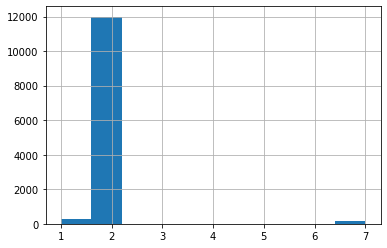

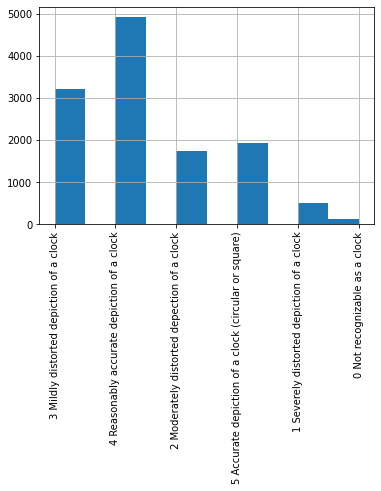

In [28]:
# Check balance of dataset
a = rounds_clean.hc1disescn9.hist() 
plt.show(a) 
b = rounds_clean.cg1dclkdraw.hist()
b.tick_params(axis='x', labelrotation = 90)
plt.show(b)

###Create Labels for the data. 

In [32]:
##NEED TO FIX Will need to create method for more than 2 rounds


# Create labels: label 0 = pre-dementia, 1 = post-dementia, 2 = normal
# Create Normal Label for all entries, base case, then assign value of 1 to 1's and 7's
rounds_clean['label'] = [2 if x == 2 else 1 for x in rounds_clean['hc1disescn9']]

# Will need to create method for more than 2 rounds
round_val = 2

round_current = rounds_clean[rounds_clean['round'] == round_val]

# assign label value of 0 to the previous round where diagnosis changed from a 2.0 to 1.0
# appears that a diagnoses value of 7 corresponds to previous round value of 1, so label stays a 1 for that subject
#post = rounds1_2.query('hc1disescn9==7 | hc1disescn9==1 & round =='+str(round_val))['spid']


post1 = round_current[(round_current['hc1disescn9'] == 1) & (round_current['round'] == round_val)]
#rounds_clean.loc[rounds_clean['spid'].isin(post1['spid']), 'label'] = 0
#rounds_clean.head()
post1
round_current

,spid,cg1dclkdraw,hc1disescn9,round,label
0,10000003.0,4 Reasonably accurate depiction of a clock,2.0,2,2
1,10000007.0,3 Mildly distorted depiction of a clock,2.0,2,2
2,10000008.0,2 Moderately distorted depection of a clock,2.0,2,2
4,10000010.0,4 Reasonably accurate depiction of a clock,7.0,2,1
8,10000017.0,5 Accurate depiction of a clock (circular or s...,2.0,2,2
...,...,...,...,...,...
7067,10012399.0,4 Reasonably accurate depiction of a clock,2.0,2,2
7068,10012400.0,3 Mildly distorted depiction of a clock,2.0,2,2
7071,10012406.0,3 Mildly distorted depiction of a clock,2.0,2,2
7072,10012407.0,4 Reasonably accurate depiction of a clock,2.0,2,2


In [29]:
##NEED TO FIX Will need to create method for more than 2 rounds


# Create labels: label 0 = pre-dementia, 1 = post-dementia, 2 = normal
# Create Normal Label for all entries, base case, then assign value of 1 to 1's and 7's
rounds_clean['label'] = [2 if x == 2 else 1 for x in rounds_clean['hc1disescn9']]

# Will need to create method for more than 2 rounds
round_val = 2

# assign label value of 0 to the previous round where diagnosis changed from a 2.0 to 1.0
# appears that a diagnoses value of 7 corresponds to previous round value of 1, so label stays a 1 for that subject
#post = rounds1_2.query('hc1disescn9==7 | hc1disescn9==1 & round =='+str(round_val))['spid']
post1 = rounds_clean[(rounds_clean['hc1disescn9'] == 1) & (rounds_clean['round'] == round_val)]
rounds_clean.loc[rounds_clean['spid'].isin(post1['spid']), 'label'] = 0
rounds_clean.head()

,spid,cg1dclkdraw,hc1disescn9,round,label
29,10000047.0,3 Mildly distorted depiction of a clock,1.0,2,1
75,10000130.0,5 Accurate depiction of a clock (circular or s...,1.0,2,1
343,10000583.0,4 Reasonably accurate depiction of a clock,1.0,2,1
954,10001636.0,4 Reasonably accurate depiction of a clock,1.0,2,1
1160,10002002.0,3 Mildly distorted depiction of a clock,1.0,2,1
...,...,...,...,...,...
6486,10011363.0,1 Severely distorted depiction of a clock,1.0,2,1
6512,10011404.0,2 Moderately distorted depection of a clock,1.0,2,1
6594,10011553.0,3 Mildly distorted depiction of a clock,1.0,2,1
6676,10011705.0,5 Accurate depiction of a clock (circular or s...,1.0,2,1


In [30]:
post1.head(50)

,spid,cg1dclkdraw,hc1disescn9,round,label
29,10000047.0,3 Mildly distorted depiction of a clock,1.0,2,1
75,10000130.0,5 Accurate depiction of a clock (circular or s...,1.0,2,1
343,10000583.0,4 Reasonably accurate depiction of a clock,1.0,2,1
954,10001636.0,4 Reasonably accurate depiction of a clock,1.0,2,1
1160,10002002.0,3 Mildly distorted depiction of a clock,1.0,2,1
1219,10002101.0,2 Moderately distorted depection of a clock,1.0,2,1
1277,10002197.0,3 Mildly distorted depiction of a clock,1.0,2,1
1280,10002200.0,1 Severely distorted depiction of a clock,1.0,2,1
1297,10002229.0,0 Not recognizable as a clock,1.0,2,1
1404,10002433.0,1 Severely distorted depiction of a clock,1.0,2,1


In [ ]:
#Checking for 
#rounds1_10.reset_index(inplace = True)
#rounds1_10.drop(columns=["index","cg1dclkdraw"], inplace = True)
#ids = rounds1_10[rounds1_10['hc1disescn9'] == 2]['spid'].values
#stop = 0

#for id in ids:
  #print(rounds1_10.loc[rounds1_10['spid'] == id])
  #stop +=1
  #if stop == 10:
    #break




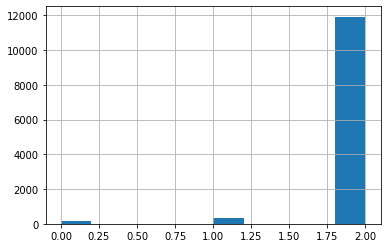

In [ ]:
# Look at distribution of labels
import matplotlib.pyplot as plt

rounds1_10.label.hist() #Highly unbalanced dataset - good case for generating synthetic data to rebalance

###Loading Image Data from AWS S3 Bucket


In [34]:
!aws s3 ls s3://clockdrawingimages1/10000003.tif
#!aws configure

Unable to locate credentials. You can configure credentials by running "aws configure".


In [ ]:
s3 = boto3.resource('s3', region_name = 'us-west-1')
bucket = s3.Bucket('clockdrawingimages1')
object = bucket.Object('10000003.tif')
response = object.get()

# Read single image data into memory and save to variable
file_stream = response['Body']
im = Image.open(file_stream) #Actual image

# Convert image to array as binary values, black values will 
#get the true value using np.logical_not
r1_image = np.logical_not(np.array(im)).astype(int) # Binary Array
r1_image2 = np.array(im) #Bool Array
#image = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/10000003.tif', cv2.IMREAD_GRAYSCALE)
r1_image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

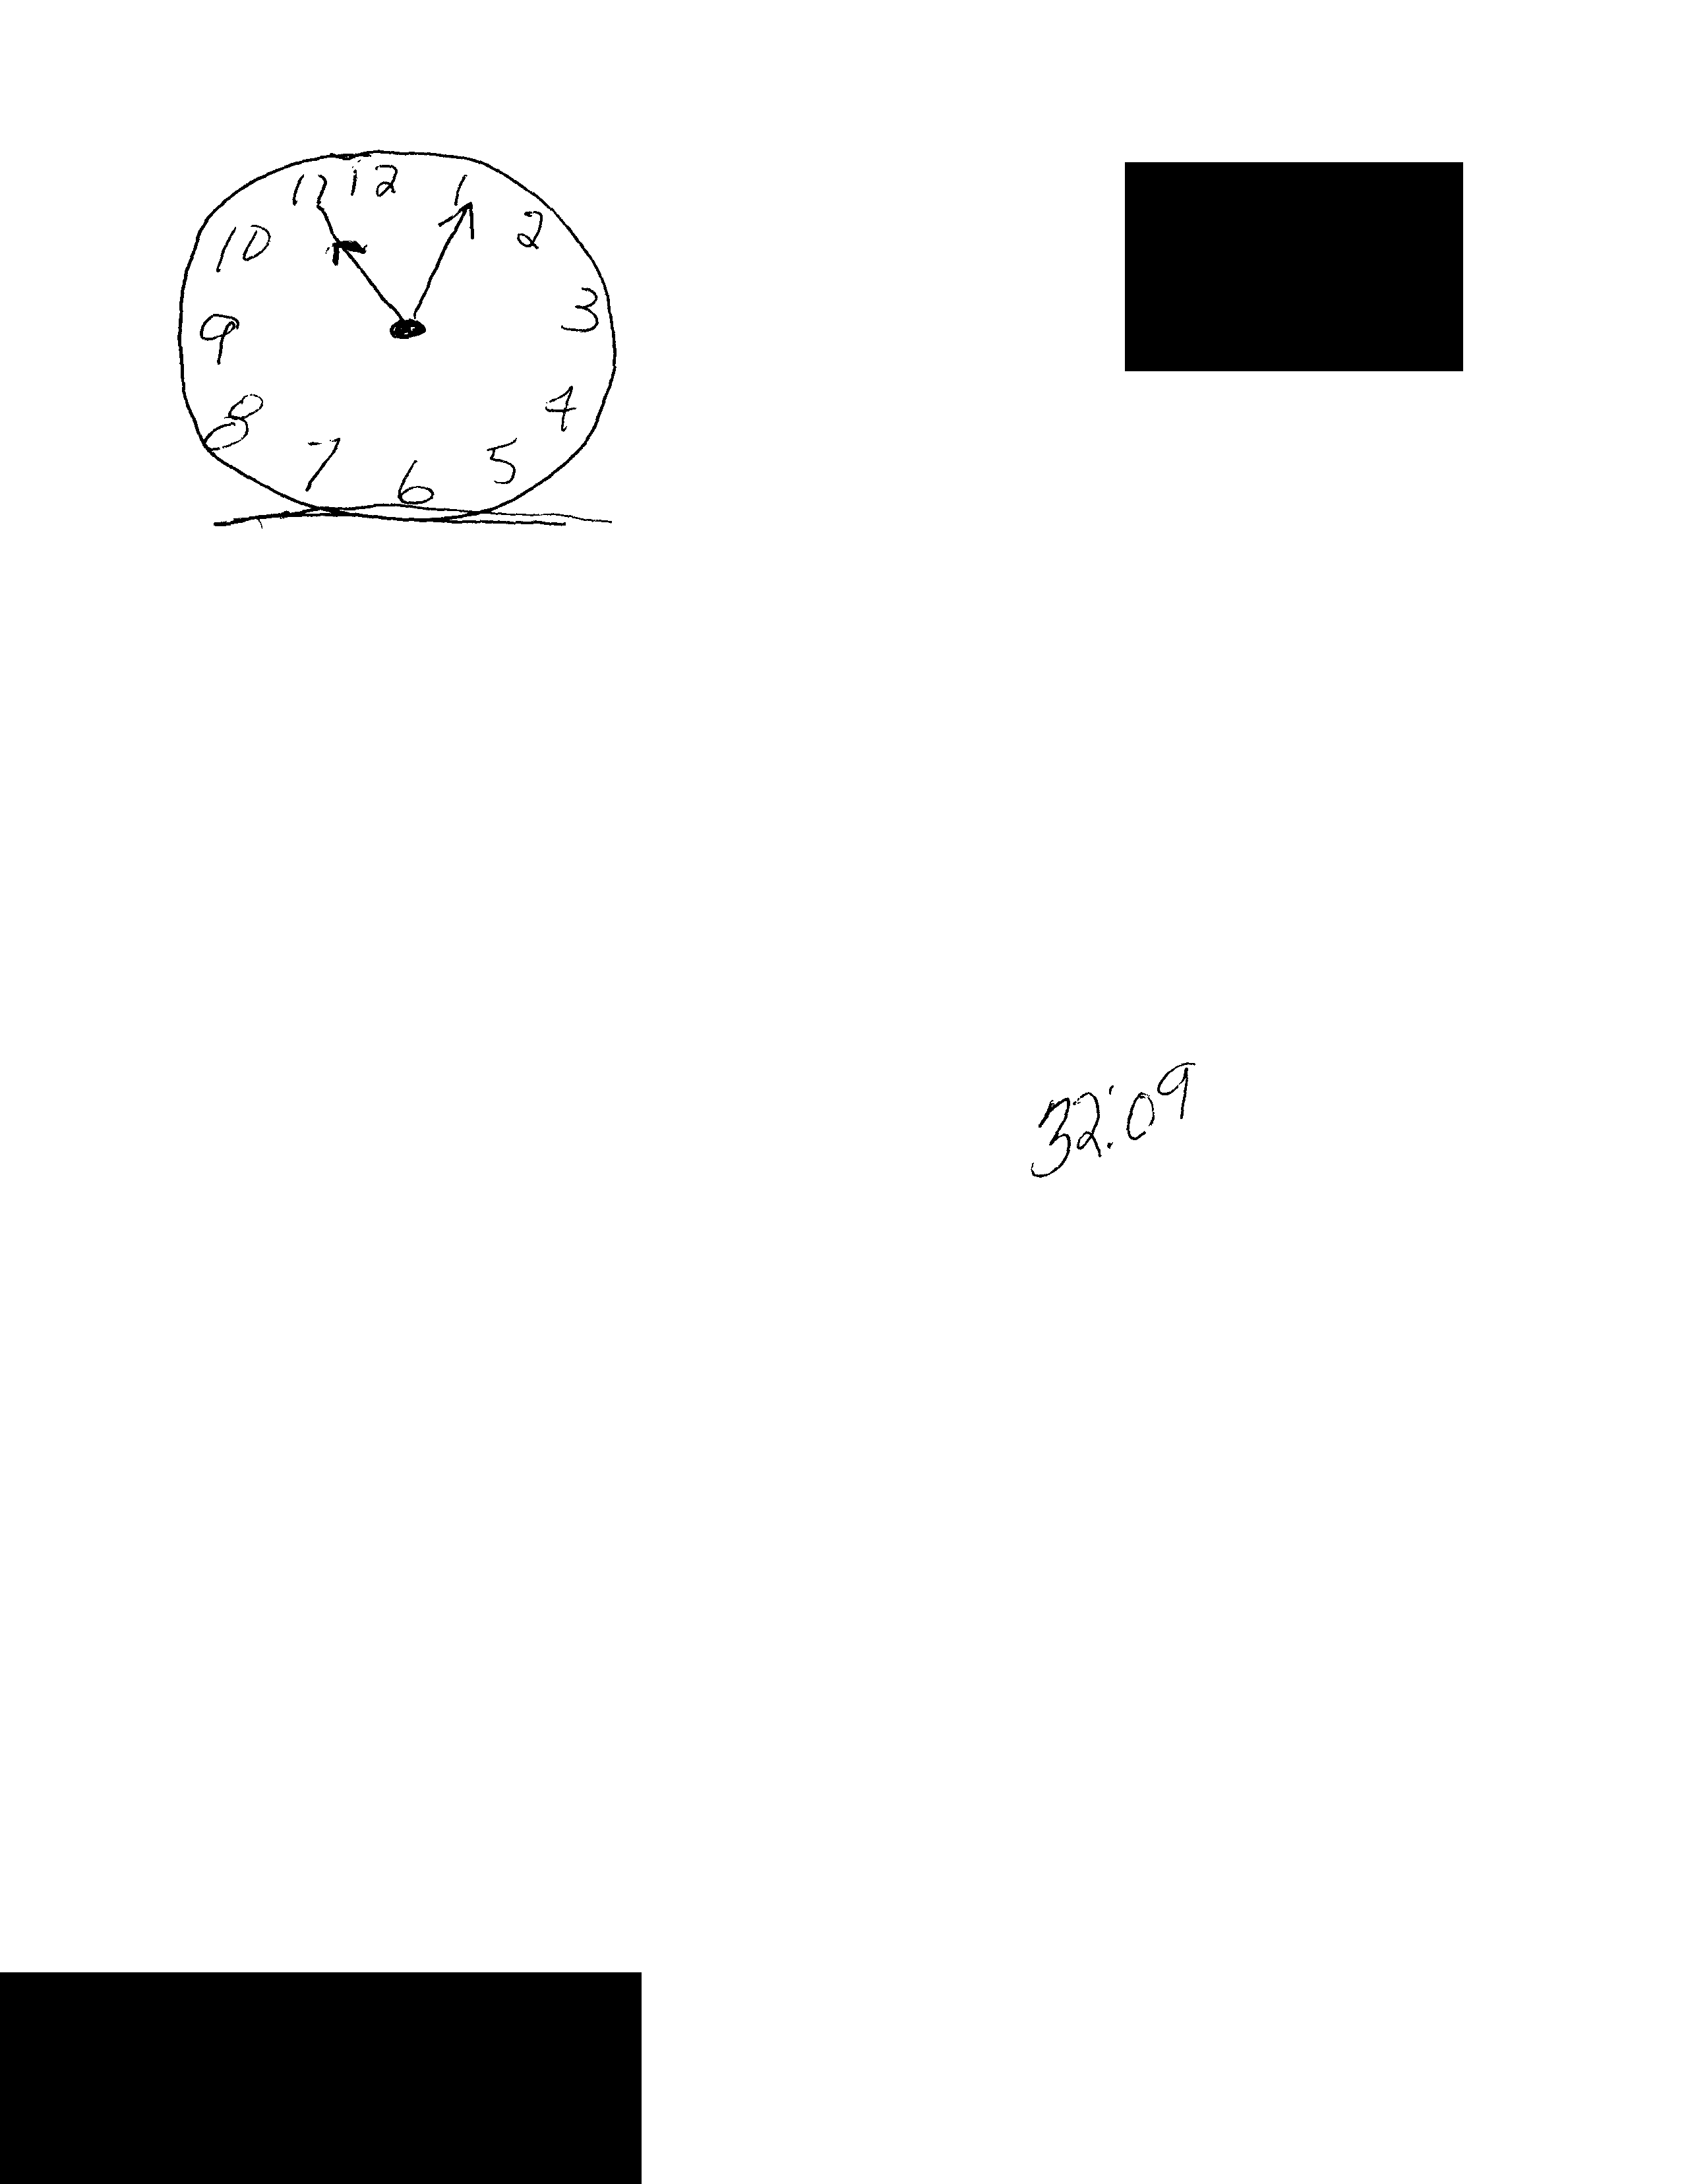

In [ ]:
# revert
im = Image.fromarray(r1_image2)
im

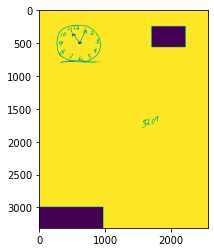

In [ ]:
plt.imshow(r1_image2)

In [ ]:
--